## Why model? 

Let's consider a data-set taken from an experiment in visual neuroscience. In this experiment, participants viewed a stimulus that contained a grating. In each trial two gratings were displayed. To show these stimuli, let's import some stuff from IPython: 

Populating the interactive namespace from numpy and matplotlib


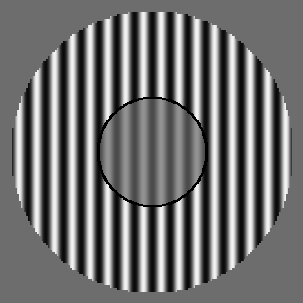

In [1]:
from IPython.display import display, Image
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)
%pylab inline

display(Image(filename='images/surrounded.png'))

The first grating that was shown was surrounded by another grating: 

The second grating was not surrounded: 


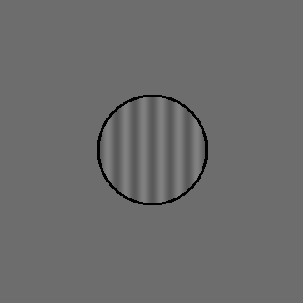

In [2]:
display(Image(filename='images/comparison.png'))

Participants had to say which interval had higher contrast. That is, in which interval the amplitude of the modulation between the dark stripes and the light stripes in the grating was larger. This is a way for us to measure the effects of the presencee of a surround on contrast perception. For example, it is well known that the relative orientation of the surround affects the degree to which the surround reduces the perceived contrast of the central patch (e.g., see recent work from Kosovicheva et al. using a similar experimental paradigm).

Let's look at some experimental data. We have two files from one subject in csv files, ortho.csv and para.csv. As their names suggest they come from two different runs of the experiment: one in which the surrounding stimulus was oriented in the parallel orientation relative to the center stimulus (also sometimes called 'co-linear') and one in which the surrounding stimulus was orthogonal to the center stimulus. The files contain three columns: contrast1 is the contrast in the first interval, contrast2 is the contrast in the second interval and answer is what the participant thought had higher contrast. We will use the function mlab.csv2rec to read the data into a numpy recarray:

In [3]:
import numpy as np
def csv2rec(filename):
    return np.recfromtxt(filename, dtype=None, delimiter=',', names=True, encoding='utf-8')

In [4]:
ortho = csv2rec('data/ortho.csv') 
para = csv2rec('data/para.csv')

ortho_df = pd.read_csv('data/ortho.csv') 
para_df = pd.read_csv('data/para.csv')

ortho_df.head(3)

,contrast1,contrast2,answer
0,0.60,0.3,1
1,0.65,0.3,1
2,0.70,0.3,1


In [5]:
np.unique(ortho_df.contrast1)

array([0.01, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.9 ])

In [6]:
idx = np.where(ortho_df.contrast1 == 0.01)
print(idx[0])

[  5  20  25  29  37  47  50  55  58 125 152 158 174]


If you take a look at the data you will see that the contrast in the second interval was always 0.3 (30% contrast), so we can safely ignore that column altogether and only look at the contrast in the first interval. Let's take a look at the data. First, we are just going to plot the raw data as it is. We will consider the contrasts as our independent variable, and the responses as the dependent variables.

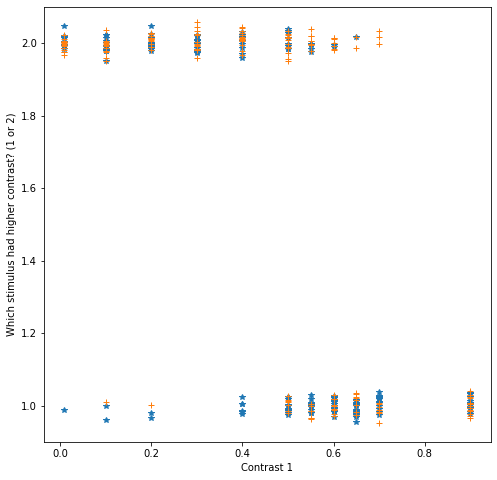

In [7]:
fig, ax = plt.subplots(1)
# We apply a small vertical jitter to each point, just to show that there are multiple points at each location:
ax.plot(ortho['contrast1'], ortho['answer'] + np.random.randn(len(ortho)) * 0.02 , '*')
ax.plot(para['contrast1'], para['answer'] + np.random.randn(len(para)) * 0.02 , '+')
ax.set_ylim([0.9, 2.1])
ax.set_xlabel('Contrast 1')
ax.set_ylabel('Which stimulus had higher contrast? (1 or 2)')

fig.set_size_inches([8,8])

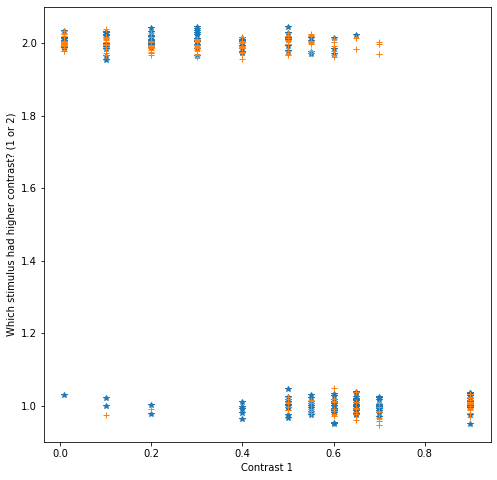

In [8]:
fig, ax = plt.subplots(1)
# We apply a small vertical jitter to each point, just to show that there are multiple points at each location:
ax.plot(ortho_df['contrast1'], ortho_df['answer'] + np.random.randn(len(ortho)) * 0.02 , '*')
ax.plot(para_df['contrast1'], para_df['answer'] + np.random.randn(len(para)) * 0.02 , '+')
ax.set_ylim([0.9, 2.1])
ax.set_xlabel('Contrast 1')
ax.set_ylabel('Which stimulus had higher contrast? (1 or 2)')

fig.set_size_inches([8,8])

There seems to be a trend in the data: the larger the contrast in the first interval, the more likely the subject was to press the '1' button. That's a reasonable thing to do, but it's hard to see and hard to quantify in this form. Instead, we will transform this data into a plot in which the independent variable is the contrast in interval 1 and the dependent variable is the proportion of trials for which the subject pressed the '1' key for each contrast. Let's define a function that will do that for us: 

In [9]:
def transform_data(data): 
    #print(data)
    """ 
    Function that takes experimental data and gives us the dependent/independent variables for analysis

    Parameters
    ----------

    data : rec array 
        The data with records: `contrast1`, `contrast2` and `answer`

    Returns
    -------
    x : The unique contrast differences. 
    y : The proportion of '1' answers in each contrast difference
    n : The number of trials in each x,y condition 
    """
    contrast1 = data['contrast1']
    answers = data['answer']
    
    x = np.unique(contrast1)
    y = []
    n = []

    for c in x:
        idx = np.where(contrast1 == c)
        n.append(float(len(idx[0])))
        answer1 = len(np.where(answers[idx] == 1)[0])
        y.append(answer1 / n[-1])
    return x,y,n
            

In [10]:
x_ortho, y_ortho, n_ortho = transform_data(ortho)
x_para, y_para, n_para = transform_data(para)    

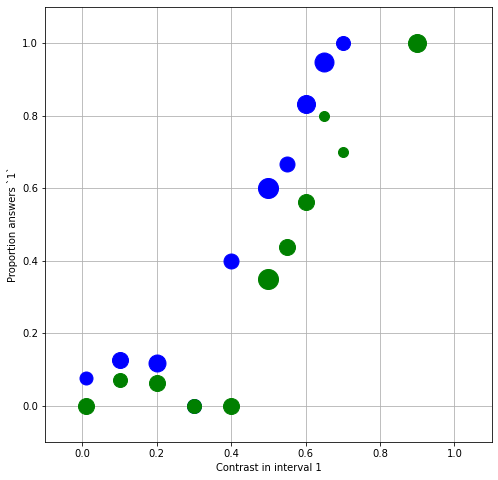

In [11]:
fig, ax = plt.subplots(1)
# To plot each point with size proportional to the number of trials in that condition:
for x,y,n in zip(x_ortho, y_ortho, n_ortho):
    ax.plot(x, y, 'bo', markersize=n)

for x,y,n in zip(x_para, y_para, n_para):
    ax.plot(x, y, 'go', markersize=n)

ax.set_xlabel('Contrast in interval 1')
ax.set_ylabel('Proportion answers `1`')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

Obviously there is a systematic relationship between the contrast and the chances that this subject thought that the first interval had the higher contrast. For example, when the contrast was much higher in interval 1 (e.g. 0.9), this person never said that the second interval had higher contrast. Likewise, when the contrast was very low, this person almost never said that the contrast in interval 1 had been higher. In the middle, there seems to be a monotonic relationship between the variables. Also, notive that the two sets of data (orthogonal and parallel) seem to be slightly different. 

Can we say something more precise? For example, we might be interested in the contrast in which 50% of the answers would have been '1' and 50% of the answers would have been '2'. This is known as the point of subjective equality (or PSE) and we can use it to compare different conditions in this experiment and in other experiments, between different subjects, etc. 

In order to derive this quantity, we will have to fit a model to the data. 

*Note: If were doing this in earnest, we would take into account the number of trials that was performed at each contrast (especially given that there are more trials in some conditions). For the purpose of this tutorial, we will ignore that.*

## Models and why we like them

Models derived from data are useful for several reasons: 

- **They allow you to explain the data you have**: summary statistics of the data, such as the mean of some variable, or the variance of this variable, are often not the best explanation of the data you have observed, in terms of the theory. For example, in the data we have observed in our experiment, a useful quantity is the PSE, which telss us what the *perceived contrast* of the surrounding grating was. This quantity is not readily present in summary statistics of the data. A *functional form* of a model is a mathematical formula that relates systematic changes in measured dependent variables, based on experimental manipulations of the independent variables. The functional form of the model varies with changes in *model parameters*. In the typical case, parameters are variables specificied in the model, that are neither your dependent variables nor your independent variables. If the model parameters correspond to theoretically meaningful quantities (such as the PSE), that can make the model useful in explaining the data and help test hypotheses about the theory behind the experiment.

- **They allow you to predict data you haven't collected**: In many cases, assuming that the parameters don't change with changes in the independent variables, models allow us to interpolate and predict what the dependent variables would have been like in other values of the independent variables. Even extrapolate to conditions that have not measured. For example, because measuring in these conditions is difficult for practical reasons. 

- **They allow us to build theories**: By applying a modeling approach to data, we can hope to build an incremental knowledge abouth the domain we are studying. For example, [Newton's law of gravitation](http://en.wikipedia.org/wiki/Newton's_law_of_universal_gravitation) provides us with a quantitative prediction on the behavior of any two bodies. The observation that this model does not perform well in all conditions, led to [Einstein's theory of general relativity](http://en.wikipedia.org/wiki/General_relativity), which provides a generalization of this law (model).



# Different kinds of models

## Linear models
The main distinction we will make here is between *linear* models and *non-linear* models. Linear models are models that can be described by the following functional form: 

$\bf{y} = \beta_0 + \beta_1 \bf{x}_1 + \beta_2 \bf{x}_2 + ... + \beta_n \bf{x}_n + \epsilon$, 

where $\bf{y}$ denotes the dependent variable or variables (that's why it's bold-faced: it could be a vector!) in your experiment. $\bf{x}_i$ are sets of dependent variables (also, possibly vectors) and $\beta_i$ are parameters. Finally, $\epsilon$ is the noise in the experiment. You can also think about $\epsilon$ as all the things that your model doesn't know about. For example, in the visual experiment described, changes in participants wakefulness might affect performance in a systematic way, but unless we explicitely measure wakefulness and add it as an independent variable to our analysis (as another $\bf{x}$), we don't know it's value on each trial and it goes into the noise. 

Linear models are easy to fit. Under some fairly generic assumptions (for example that $\epsilon$ has a zero-mean normal distribution), there is actually an analytic solution to this problem. That is, you can plug it into a formula and get the exact solution: the set of $\beta$ that give you the smallest sum-of-squared-errors (SSE) between the data you collected and the function defined by the parameters (we will assume that this is your objective, though variataions on this do exist). This is the reason that if you can transform your data somehow to get it into a linear form, you should definitely do that. 

Let's fit a linear model to our data. In our case, a linear model would simply be a straight line: 

$y = \beta_0 + \beta_1 x$

These kind of equations (*polynomials*) can be solved using `np.polyfit`:

In [12]:
# Note that the coefficients go in the other direction than my equation above (the constant comes last):
beta1_ortho, beta0_ortho = np.polyfit(x_ortho, y_ortho, 1)
beta1_para, beta0_para = np.polyfit(x_para, y_para, 1)

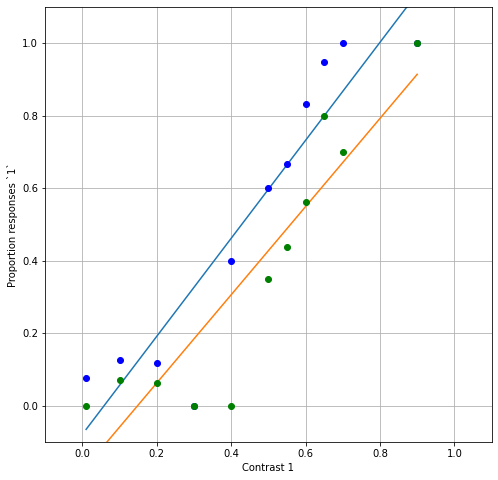

In [13]:
# Let's show the data and the model fit, 
# polyval evaluates the model at an arbitrary set of x values:
x = np.linspace(np.min([x_ortho, x_para]), np.max([x_ortho, x_para]), 100)
fig, ax = plt.subplots(1)
ax.plot(x, np.polyval([beta1_ortho, beta0_ortho], x))
ax.plot(x_ortho, y_ortho, 'bo')
ax.plot(x, np.polyval([beta1_para, beta0_para], x))
ax.plot(x_para, y_para, 'go')
ax.set_xlabel('Contrast 1')
ax.set_ylabel('Proportion responses `1`')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

In [14]:
#Let's quantify the fit by calculating the sum of squared errors relative to the actual data: 
SSE_ortho = np.sum((y_ortho - np.polyval([beta1_ortho, beta0_ortho], x_ortho))**2)
SSE_para = np.sum((y_para - np.polyval([beta1_para, beta0_para], x_para))**2)
print(SSE_ortho + SSE_para)

0.4355681230236349


In this case, to derive the PSE, we need to do a little bit of algebra. We set y=0.5 (that's the definition of the PSE) and solve for x:

$0.5 = \beta_0 + \beta_1 x$

$ \Rightarrow 0.5 - \beta_0 = \beta_1 x$ 

$ \Rightarrow x = \frac{0.5- \beta_0}{\beta1}$


In [15]:
print('PSE for the orthogonal condition is:%s'%((0.5 - beta0_ortho)/beta1_ortho))
print('PSE for the parallel condition is:%s'%((0.5 - beta0_para)/beta1_para))

PSE for the orthogonal condition is:0.4284137202299222
PSE for the parallel condition is:0.5596503722422845


OK - this model seems to capture some aspects of the data rather well. For one, it is monotonically increasing. And the SSE doesn't seem too bad (though that's hard to assess just by looking at this number). This model tells us that the PSE is at approximately 0.43 for orthogonal condition and approximately 0.56 for the parallel condition. That is, the contrast in the first interval has to be higher than the contrast in the second interval to appear exactly the same. By how much? For the orthogonal condition it's about 13% and for the parallel condition it's about 26% (considering that the comparison contrast is always 30%). This makes sense: more suppression for the parallel relative to the orthogonal condition. But there are a few problems with this model: It seems to miss a lot of the points. That could be because the data is very noisy, but we can see that the model systematically overshoot the fit for high values of x and systematically undershoots for low values of x. This indicates that another model might be better for this data. Another problem is that it seems to produce non-sensical values for some conditions. For example, it sometimes predicts values larger than 1.0 for large contrasts and values smaller than 0.0 for small contrasts. These values are meaningless, because proportion of responses can never be outside the range 0-1. We need to find a different model.   

# Non-linear models:

Unfortunately, linear models don't always fit our data. As shown above, they might produce large and systematic fit error, or they might produce values that don't make sense. In these cases, we might need to fit a non-linear model to our data. Non-linear models cannot be described as above and are generally described by the following functional form: 

$\bf{y} = f(\bf{x}_1, \bf{x}_2, ... \bf{x}_n, \bf{\beta}) + \epsilon$, 

Where $f()$ can be almost any function you can think of that takes $x$'s and $\beta$'s as input. The problem is that there is no formula that you can just plug your function into and derive the values of the parameters. One way to find the value of the parameters for a given functional form is to use optimization. In this process, the computer systematically tries out different values of $\beta$ and finds a set of these values that minimizes the SSE relative to the data. There are many different optimization algorithms and we will use one, a variant of the Levenberg-Marquardt algorithm, implemented in `scipy.optimize` as `leastsq`.

## Step 1 : define the function
To perform optimization, we need to define the functional form of our model. For this kind of data, a common model to use (e.g in [work by Yu and Levi](http://ww.journalofvision.org/content/2/3/4.full)) is a cumulative Gaussian function. The Gaussian distribution is parameterized by 2 numbers, the mean and the variance, so as in the linear model shown above, this model has 2 parameters: 

$y(x) = \frac{1}{2}[1 + erf(\frac{x-\mu}{\sigma \sqrt{2} })]$, 

where $erf$ is the so-called 'error function', implemented in `scipy.special`


In [16]:
from scipy.special import erf
def cumgauss(x, mu, sigma):
    """
    The cumulative Gaussian at x, for the distribution with mean mu and
    standard deviation sigma. 

    Parameters
    ----------
    x : float or array
       The values of x over which to evaluate the cumulative Gaussian function

    mu : float 
       The mean parameter. Determines the x value at which the y value is 0.5
   
    sigma : float 
       The variance parameter. Determines the slope of the curve at the point of 
       Deflection
    
    Returns
    -------

    Notes
    -----
    Based on:
    http://en.wikipedia.org/wiki/Normal_distribution#Cumulative_distribution_function

    """
    return 0.5 * (1 + erf((x-mu)/(np.sqrt(2)*sigma)))


The doc-string specifies one reason that we might want to use this function for this kind of data: one of the parameters of the function (mu) is simply the definition of the PSE. So, if we find this parameter, we already have the PSE in hand, without having to do any extra algebra. 

Let's plot a few exemplars of this function, just to get a feel for them:

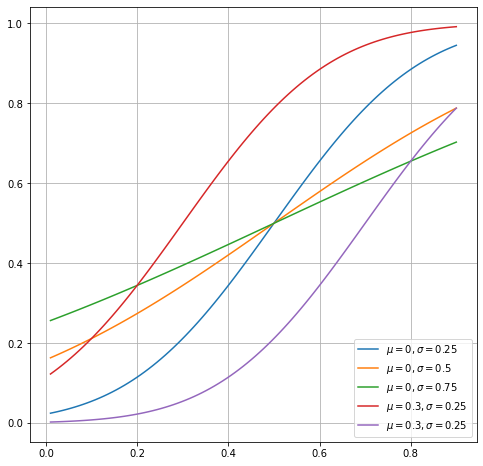

In [17]:
fig, ax = plt.subplots(1)
ax.plot(x, cumgauss(x, 0.5, 0.25), label=r'$\mu=0, \sigma=0.25$')
ax.plot(x, cumgauss(x, 0.5, 0.5), label=r'$\mu=0, \sigma=0.5$')
ax.plot(x, cumgauss(x, 0.5, 0.75), label=r'$\mu=0, \sigma=0.75$')
ax.plot(x, cumgauss(x, 0.3, 0.25), label=r'$\mu=0.3, \sigma=0.25$')
ax.plot(x, cumgauss(x, 0.7, 0.25), label=r'$\mu=0.3, \sigma=0.25$')
#ax.set_ylim([-0.1, 1.1])
#ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])
plt.legend(loc='lower right')

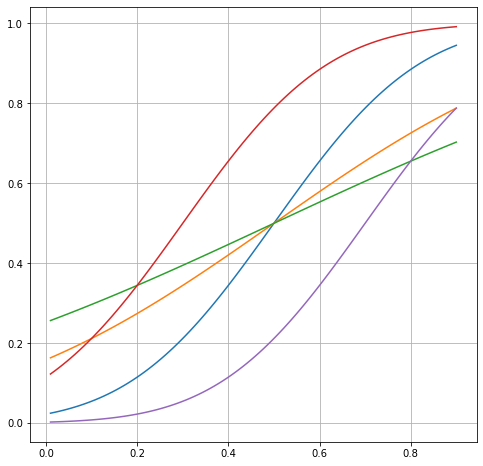

In [18]:
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st

fig, ax = plt.subplots(1) 
plt.plot(x, st.norm.cdf(x, loc = 0.5,scale=0.25))
plt.plot(x, st.norm.cdf(x, loc = 0.5,scale=0.5))
plt.plot(x, st.norm.cdf(x, loc = 0.5,scale=0.75))
plt.plot(x, st.norm.cdf(x, loc = 0.3,scale=0.25))
plt.plot(x, st.norm.cdf(x, loc = 0.7,scale=0.25))

fig.set_size_inches([8,8])
ax.grid('on')

As you can see, these are monotonically increasing functions. For different values of $\mu$, the function moves left or right. As it is derived from the Gaussian function, it asymptotes at 0 and 1 at $-\infty$ and $+\infty$ respectively, and the rate at which it approaches these asymptotes on either side is determined by $\sigma$. 

## Step 2 : define an error function

The next step in the optimization procedure is to define an error-function, which can take this function, a particular set of data and a particular set of parameters and calculates the errors in fitting the function, relative to the data, given a particular set of parameters. These errors are also sometimes referred to as the *marginals* of the fitting proedure. In our optimization procedure, we will aim to minimize the sum of the squares of these marginals. If you want to optimize another cost-function (for example, sometimes you might want to minimize the *sum of the absolute error*, instead of the SSE), this is where you would implement this variation

In [19]:
def err_func(params, x, y, func):
        """
        Error function for fitting a function
        
        Parameters
        ----------
        params : tuple
            A tuple with the parameters of `func` according to their order of input

        x : float array 
            An independent variable. 
        
        y : float array
            The dependent variable. 
        
        func : function
            A function with inputs: `(x, *params)`
        
        Returns
        -------
        The marginals of the fit to x/y given the params
        """
        return y - func(x, *params)

Notice that we are passing a function as an input to this function. This might be a pattern that you have never seen before, but when you think about it, there's nothing special about a function that doesn't allow us to pass it around as an object (well, that's not entirely true, functions are special, but bear with me). Note also that we have implemented this function to take *any* function as input and the `params` can be any tuple of parameters with any length. This will allow us to reuse this function later on for other models with a different number of parameters. 

## Step 3 : optimize!

We import the `scipy.optimize` module and deploy `leastsq`: 

In [20]:
import scipy.optimize as opt
# Let's guess the inital conditions: 
initial = 0,0.5
# We get the params, and throw away the second output of leastsq:
params_ortho, _ = opt.leastsq(err_func, initial, args=(x_ortho, y_ortho, st.norm.cdf))
params_para, _ = opt.leastsq(err_func, initial, args=(x_para, y_para, st.norm.cdf))

## Step 4 : evaluate

Let's compare this to the data: 

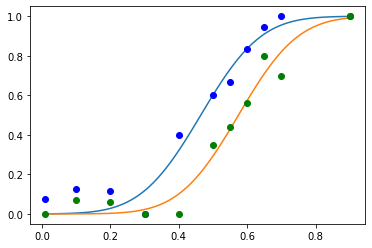

In [21]:
plot(x, cumgauss(x, params_ortho[0], params_ortho[1]))
plot(x, cumgauss(x, params_para[0], params_para[1]))
plot(x_ortho, y_ortho, 'bo')
plot(x_para, y_para, 'go')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

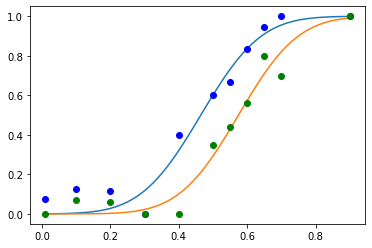

In [22]:
params_ortho, _ = opt.leastsq(err_func, initial, args=(x_ortho, y_ortho, cumgauss))
params_para, _ = opt.leastsq(err_func, initial, args=(x_para, y_para, cumgauss))
plot(x, cumgauss(x, params_ortho[0], params_ortho[1]))
plot(x, cumgauss(x, params_para[0], params_para[1]))
plot(x_ortho, y_ortho, 'bo')
plot(x_para, y_para, 'go')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

In [23]:
SSE_ortho = np.sum((y_ortho - cumgauss(x_ortho, *params_ortho))**2)
SSE_para = np.sum((y_para - cumgauss(x_para, *params_para))**2)
print(SSE_ortho + SSE_para)

0.10168723156130474


In [24]:
SSE_ortho = np.sum(err_func(params_ortho,x_ortho,y_ortho, st.norm.cdf)**2)
SSE_para = np.sum((y_para - st.norm.cdf(x_para, *params_para))**2)
print(SSE_ortho + SSE_para)

0.10168723156130478


## Step 5 : interpert

In this case, one of the parameters is simply the PSE:

In [25]:
print('PSE for the orthogonal condition is:%s'%params_ortho[0])
print('PSE for the parallel condition is:%s'%params_para[0])

PSE for the orthogonal condition is:0.46438643428400045
PSE for the parallel condition is:0.5745673476379232


Notice that we have managed to reduce the sum-of-squared error substantially relative to the linear model presented above, but it's still not perfect. How about trying a more complicated model, with more parameters. Another function that is often used to fit psychometric data is the Weibull cumulative distribution function, named after the great Swedish mathematician and engineer [Waloddi Weibull](http://en.wikipedia.org/wiki/Waloddi_Weibull)

In [26]:
def weibull(x,threshx,slope,guess,flake):
    """ 
    The Weibull cumulative distribution function

    Parameters 
    ---------- 
    x : float or array
       The values of x over which to evaluate the cumulative Weibull function
    
    threshx : float
       The value of x at the deflection point of the function. For a guess set to 0.5, this is at approximately 0.81 

    slope : float
        The slope of the function at the deflection point. 

    guess : float
        The guess rate. Between 0 and 1. For example, for a two-alternative forced-choice experiment, this would be 0.5
    
    flake : float 
        The upper asymptote of the function. Often thought of as indicative of lapses in performance ('flake rate')
    """
    threshy = 1 - (1 - guess) * np.exp(-1)
    flake = 1 - flake 
    k = (-np.log((1 - threshy) / (1 - guess))) ** (1 / slope)
    return (flake - (flake - guess) * np.exp(-(k * x / threshx) ** slope))

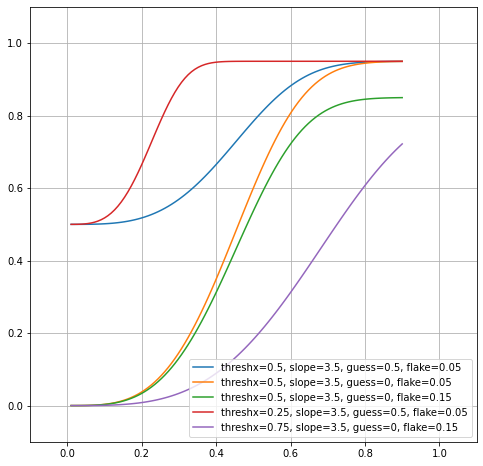

In [27]:
fig, ax = plt.subplots(1)
ax.plot(x, weibull(x, 0.5, 3.5, 0.5, 0.05), label='threshx=0.5, slope=3.5, guess=0.5, flake=0.05')
ax.plot(x, weibull(x, 0.5, 3.5, 0, 0.05), label='threshx=0.5, slope=3.5, guess=0, flake=0.05')
ax.plot(x, weibull(x, 0.5, 3.5, 0, 0.15), label='threshx=0.5, slope=3.5, guess=0, flake=0.15')
ax.plot(x, weibull(x, 0.25, 3.5, 0.5, 0.05), label='threshx=0.25, slope=3.5, guess=0.5, flake=0.05')
ax.plot(x, weibull(x, 0.75, 3.5, 0, 0.15), label='threshx=0.75, slope=3.5, guess=0, flake=0.15')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])
plt.legend(loc='lower right')

As you can see, this function has more parameters, so it can probably account for more different shapes of data.

In [28]:
# We guess the inital conditions again: 
initial = 0.5,3.5,0,0
# fit again with leastsq, this time passing weibull as the input:
params_ortho, _ = opt.leastsq(err_func, initial, args=(x_ortho, y_ortho, weibull))
params_para, _ = opt.leastsq(err_func, initial, args=(x_para, y_para, weibull))

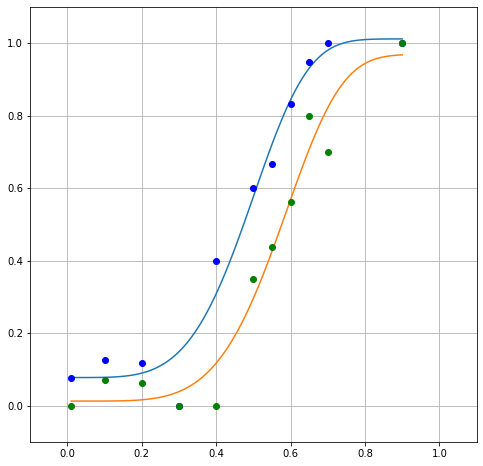

In [29]:
fig, ax = plt.subplots(1)
ax.plot(x, weibull(x, *params_ortho))
ax.plot(x, weibull(x, *params_para))
ax.plot(x_ortho, y_ortho, 'bo')
ax.plot(x_para, y_para, 'go')
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

In [30]:
SSE_ortho = np.sum((y_ortho - weibull(x_ortho, *params_ortho))**2)
SSE_para = np.sum((y_para - weibull(x_para, *params_para))**2)
print(SSE_ortho + SSE_para)

0.08648759818735413


Wow! This looks great - we've managed to reduce the SSE even more! But maybe this is too good to be true? One thing to worry about is that this model has more parameters. That is, as we noted above, it has more freedom to fit a variety of different sets of data more closely.

To understand this problem, let's consider an extreme case: consider fitting a model which is a polynomial of degree 7 to this data:

0.03938955141245391


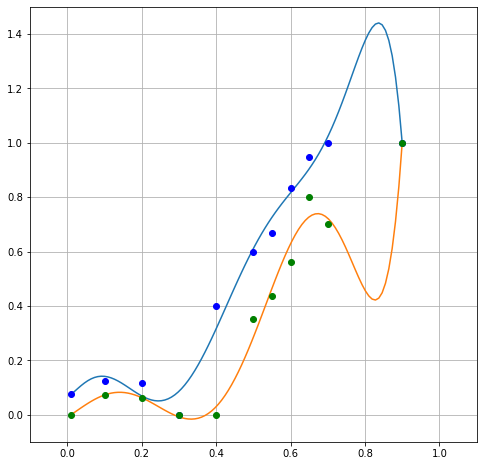

In [31]:
beta_ortho = np.polyfit(x_ortho, y_ortho, 7)
beta_para = np.polyfit(x_para, y_para, 7)

fig, ax = plt.subplots(1)
ax.plot(x, np.polyval(beta_ortho, x))
ax.plot(x_ortho, y_ortho, 'bo')
ax.plot(x, np.polyval(beta_para, x))
ax.plot(x_para, y_para, 'go')
ax.set_ylim([-0.1, 1.5])
ax.set_xlim([-0.1, 1.1])
ax.grid('on')
fig.set_size_inches([8,8])

SSE_ortho = np.sum((y_ortho - np.polyval(beta_ortho, x_ortho))**2)
SSE_para = np.sum((y_para - np.polyval(beta_para, x_para))**2)
print(SSE_ortho + SSE_para)

As you can see, the SSE is even lower, but the parameters are adjusted to fit not only the underlying trends in the data, but also the idiosyncratic characteristics of the noise in this sample, to the point where you might reach some absurd conclusions fitting this data (for example, note the deflections of the model around a contrast of 0.8) 

This model has almost as many parameters as we have data points in our data. The result is *overfitting*. How can we be sure that we were not overfitting when we fit the Weibull function to our data? 

## Model selection

Model selection refers to a process through which different models are compared to each other and one is selected over others. 

There are two general ways of doing this: 

- **Formal/parametric model comparison**: An F-test can be used to compare models that are *nested*. That is, a model in which an additional set of (one or more) parameters is added to an existing model. In addition, a few metrics have been developed to compare different models (also models that are not nested) based on the SSE and the number of parameters. [These](http://en.wikipedia.org/wiki/Bayesian_information_criterion) [metrics](http://en.wikipedia.org/wiki/Akaike_information_criterion) generally penalize a model for having many parameters and reward it for getting small SSE. However, these methods generally have some underlying assumptions and are not that transparent to understand. For a nice exposition on how to use these methods see [this paper]() (excuse the paywall...). Also, if you are interested in more on this topic, [The stats stack exchange website](http://stats.stackexchange.com/questions/20729/best-approach-for-model-selection-bayesian-or-cross-validation) is an excellent resource.


- **Cross-validation**: The method we will focus on here is cross-validation. In this method, the accuracy of a model in fitting the data is assessed by fitting the parameters on part of the data (also referred to as the *training set*) and then testing it on another, held out data set (the *testing set*). In this case, overfitting is no longer a problem, because just looking at the training set, you can't possibly fit to the idiosyncratic noise present in the testing set. Let's see how that works for the comparison of the cumulative Gaussian and the Weibull functions. 





In [32]:
# Split the data into testing and training sets:
x_ortho_1 = x_ortho[1::2]
y_ortho_1 = y_ortho[1::2]
x_ortho_2 = x_ortho[::2]
y_ortho_2 = y_ortho[::2]

x_para_1 = x_para[1::2]
y_para_1 = y_para[1::2]
x_para_2 = x_para[::2]
y_para_2 = y_para[::2]


In [33]:
initial = 0,0.5
# Fit to the training data
params_ortho_1, _ = opt.leastsq(err_func, initial, args=(x_ortho_1, y_ortho_1, cumgauss))
params_para_1, _ = opt.leastsq(err_func, initial, args=(x_para_1, y_para_1, cumgauss))
# Check SSE on the testing data:
SSE_cumgauss = (np.sum((y_ortho_2 - cumgauss(x_ortho_2, *params_ortho_1))**2) + 
                np.sum((y_para_2 - cumgauss(x_para_2, *params_para_1))**2))


# Do this again, reversing training and testing data sets: 
params_ortho_2, _ = opt.leastsq(err_func, initial, args=(x_ortho_2, y_ortho_2, cumgauss))
params_para_2, _ = opt.leastsq(err_func, initial, args=(x_para_2, y_para_2, cumgauss))
# Check SSE on the testing data:
SSE_cumgauss += (np.sum((y_ortho_1 - cumgauss(x_ortho_1, *params_ortho_2))**2) + 
                np.sum((y_para_1 - cumgauss(x_para_1, *params_para_2))**2))

print("For the cumulative Gaussian SSE=%s"%SSE_cumgauss)

# Let's do the same for the Weibull:
initial = 0.5,3.5,0,0
params_ortho_1, _ = opt.leastsq(err_func, initial, args=(x_ortho_1, y_ortho_1, weibull))
params_para_1, _ = opt.leastsq(err_func, initial, args=(x_para_1, y_para_1, weibull))
SSE_weibull = (np.sum((y_ortho_2 - weibull(x_ortho_2, *params_ortho_1))**2) + 
                np.sum((y_para_2 - weibull(x_para_2, *params_para_1))**2))

params_ortho_2, _ = opt.leastsq(err_func, initial, args=(x_ortho_2, y_ortho_2, weibull))
params_para_2, _ = opt.leastsq(err_func, initial, args=(x_para_2, y_para_2, weibull))
SSE_weibull += (np.sum((y_ortho_1 - weibull(x_ortho_1, *params_ortho_2))**2) + 
                np.sum((y_para_1 - weibull(x_para_1, *params_para_2))**2))


print("For the Weibull SSE=%s"%SSE_weibull)

For the cumulative Gaussian SSE=0.25565112357204334
For the Weibull SSE=0.28856557028368957


Note that the SSE we calculated are evaluated each time on a completely separate, non-overlapping set of data. This means that over-fitting could no longer occur, no matter how many parameters you fit. Therefore, this approach does not require counting of the number of parameters. In this case, the cumulative Gaussian seems to perform marginally better than the Weibull function, even though the Weibull has more parameters.

# Summary

This tutorial focused on fitting models to data. We examined an example of data from a psychophysical data and used the `scipy.optimize` function `leastsq` to perform an iterative fit of a non-linear model to this data. Finally, we used cross-validation to select among different models. 

This approach is, of course, not limited to psychophysical data and can be easily applied to other kinds of data. 

# Get the code

If you want to try this out for yourself, the code is in [this github repo](https://github.com/arokem/teach_optimization). Comments, feedback and pull requests most welcome. 